### Область работы 1 (библиотеки)

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, KFold, StratifiedShuffleSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn import svm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### Область работы 2 (поиск лучшей модели)

In [1]:
path_train = 'dim_train.csv'
#https://www.kaggle.com/datasets/shivam2503/diamonds

In [5]:
df = pd.read_csv(path_train)
df.shape

(40455, 10)

In [63]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.40,Premium,D,SI1,59.9,60.0,990,4.77,4.75,2.85
1,0.72,Very Good,D,VS2,61.8,58.0,3075,5.73,5.76,3.55
2,1.10,Very Good,J,SI2,61.9,55.0,4217,6.59,6.63,4.09
3,1.00,Very Good,F,VS1,62.1,60.0,6883,6.33,6.42,3.96
4,0.31,Good,G,VS2,63.6,56.0,544,4.26,4.29,2.72


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [7]:
# удаление всех сторок с нулевым значением в любом месте колонки
df = df.drop(df[df.eq(0).any(axis=1)].index)
df.shape

(40437, 10)

In [8]:
df = df.drop_duplicates()
df.shape

(40360, 10)

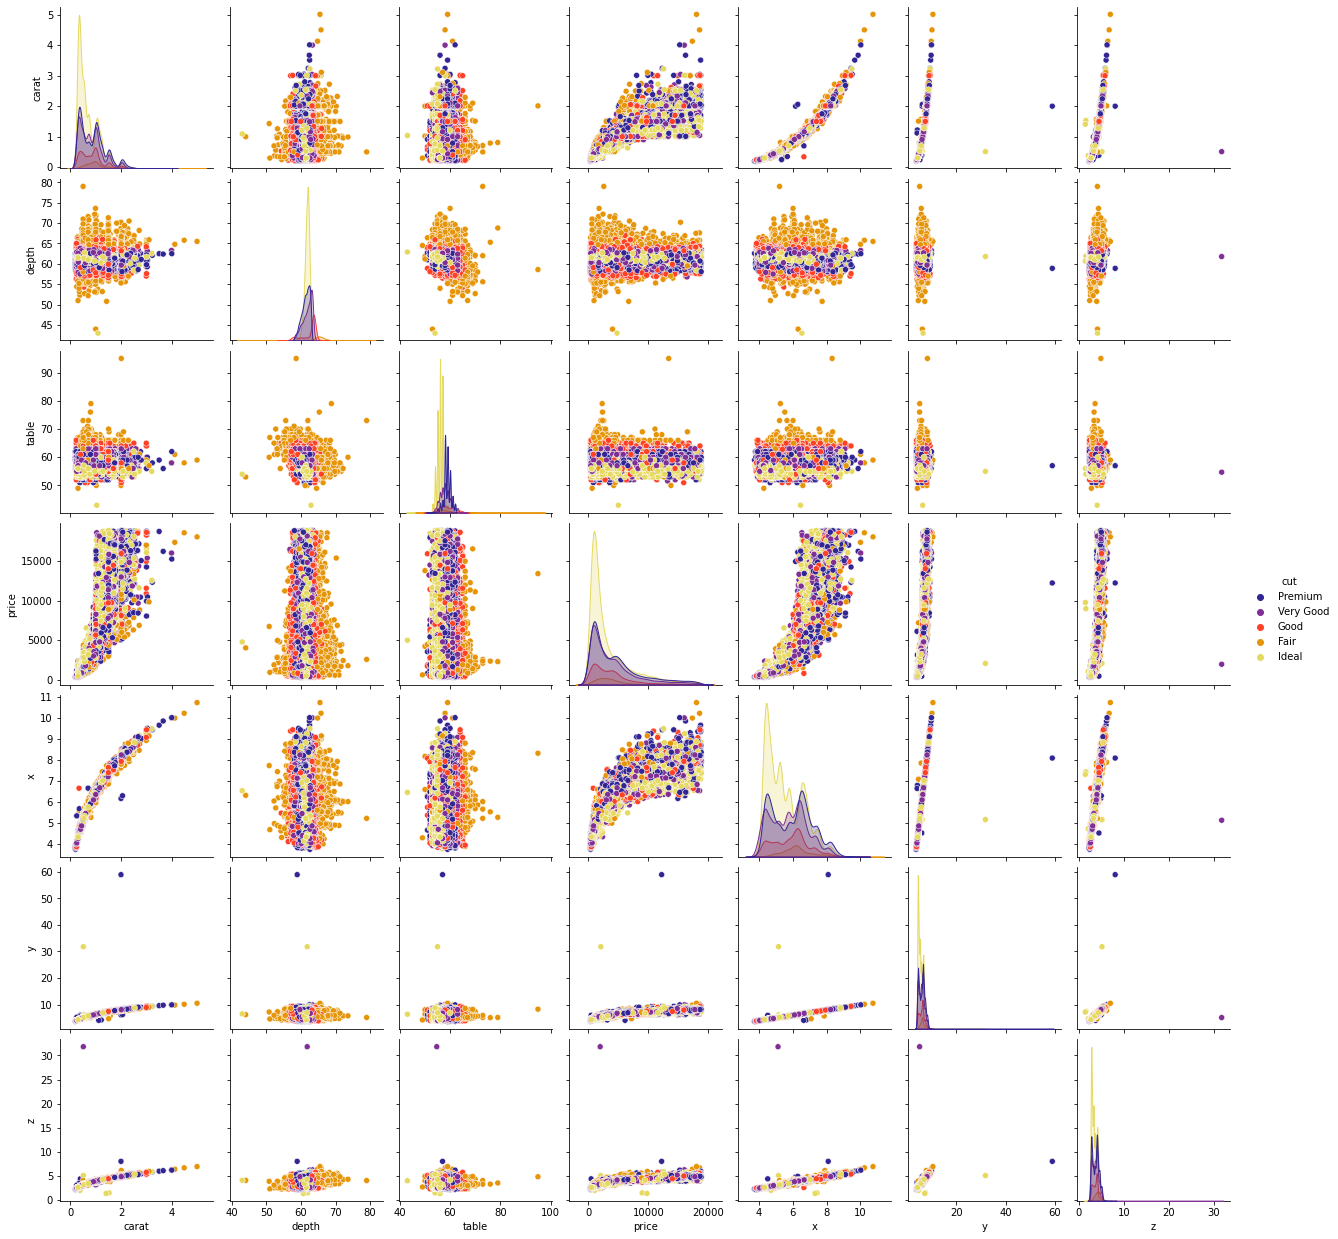

In [9]:
sns.pairplot(df, hue ='cut', palette='CMRmap');

#### На графиках прослеживается хорошая регрессионная зависимость, но с y, z, depth, table четко видны выбросы, дропнем эти значения

##### также из вывода о хорошей линейной зависимости мы можем сказать, что метод опорных векторов нам здесь не нужен (ну а еще мой ноут его просто не тянет с gridsearch, а без решетки показатели не айс - ниже посчитаны)

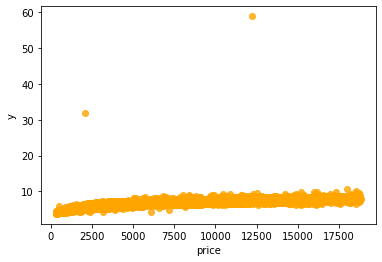

In [10]:
sns.regplot(x='price', y='y', data=df, color='orange');

тут хорошо видно, что можно удалять данные с y больше 20

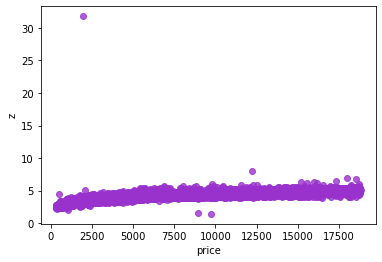

In [11]:
sns.regplot(x='price', y='z', data=df, color='darkorchid');

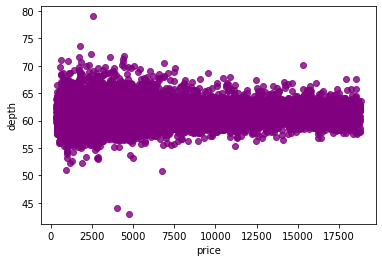

In [12]:
sns.regplot(x='price', y='depth', data=df, color='purple');
# drop <47 & >75

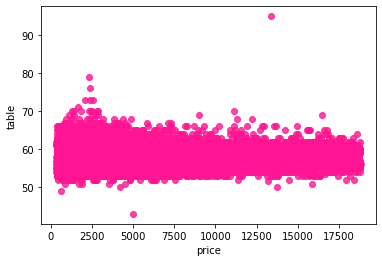

In [13]:
sns.regplot(x='price', y='table', data=df, color='deeppink');

In [14]:
#df = df.drop((df[df.table>80])|(df[df.table<45])|(df[df.depth<47])|(df[df.depth>75])|(df[df.z>20])|(df[df.y>20])) не получлось(
print(df.shape)
df = df.drop(df[df.table>80].index)
df = df.drop(df[df.table<45].index)
df = df.drop(df[df.depth<47].index)
df = df.drop(df[df.depth>75].index)
df = df.drop(df[df.z>20].index)
df = df.drop(df[df.y>20].index)
print(df.shape)

(40360, 10)
(40352, 10)


In [15]:
df.describe()

,carat,depth,table,price,x,y,z
count,40352.000000,40352.000000,40352.000000,40352.000000,40352.000000,40352.000000,40352.000000
mean,0.798040,61.750493,57.463519,3930.066118,5.732934,5.734667,3.540199
std,0.473123,1.424487,2.229815,3981.781153,1.118149,1.110198,0.690881
min,0.200000,50.800000,49.000000,326.000000,3.730000,3.710000,1.410000
25%,0.400000,61.000000,56.000000,955.000000,4.720000,4.730000,2.910000
50%,0.700000,61.800000,57.000000,2406.500000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5318.000000,6.540000,6.540000,4.030000
max,5.010000,73.600000,79.000000,18818.000000,10.740000,10.540000,6.980000


Все категориальные фичи у нас имеют иерархичный порядок (инсайдерские каггловские данные), к ним мы применяем ordinal encoding, к x,y,z применяем полиномиальный фичинг. К числовым переменным применяем StandartScaler

In [16]:
axis_features = ['x','y','z'] #для полиномиального фичинга
num_features = ['carat','depth','table'] 
y = np.array(df.price)
X = df.drop(columns=['price'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
#полиномиальный фичинг
axis_transformer = Pipeline(steps=[
    ('polynom', PolynomialFeatures(3,include_bias=False)),
    ('scaler', StandardScaler())])

#метки для прозрачности бриллианта
clarity_map = [{
    'col':'clarity',# присваиваем иерархию
    'mapping':{'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 
               'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}
    }]

clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', StandardScaler())
    ])

In [19]:
#у cut&color тоже присутствует иерархия
print(df.cut.unique())
print(df.color.unique())

['Premium' 'Very Good' 'Good' 'Ideal' 'Fair']
['D' 'J' 'F' 'G' 'H' 'E' 'I']


In [20]:
#метки для срезов
cut_map = [{'col':'cut',
            'mapping':{'Ideal':4, 'Premium':3, 'Very good':2, 'Good':1, 'Fair':0}}]

cut_transformer = Pipeline(steps=[
    ('ce', ce.OrdinalEncoder(mapping=cut_map)),
    ('scaler', StandardScaler())])

# color diamond colour, from J (worst) to D (best) из описания датасета на kaggle
#метки для цвета
color_map = [{'col':'color',
            'mapping':{'D':6,'J':5, 'F':4, 'G':3, 'H':2, 'I':1, 'J':0}}]

color_transformer = Pipeline(steps=[
    ('ce', ce.OrdinalEncoder(mapping=color_map)),
    ('scaler', StandardScaler())])

#преобразовываем наш X_train
CT = ColumnTransformer([
    ('pol_std', axis_transformer, axis_features),
    ('num', StandardScaler(), num_features),
    ('cut', cut_transformer, ['cut']),
    ('clarity', clarity_transformer, ['clarity']),
    ('color', color_transformer, ['color'])
])

display(CT)
res_ct = CT.fit_transform(X_train)
res_ct = pd.DataFrame(res_ct)
res_ct

ColumnTransformer(transformers=[('pol_std',
                                 Pipeline(steps=[('polynom',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['x', 'y', 'z']),
                                ('num', StandardScaler(),
                                 ['carat', 'depth', 'table']),
                                ('cut',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'cut',
                                                                           'mapping': {'Fair': 0,
                                                                                       'Good': 1,
                                                                                       'Ideal': 4,
                                                                                       'Premium': 3,
                                                                                       'Very good': 2}}])),...
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'mapping': {'FL': 10,
                                                                                       'I1': 2,
                                                                                       'I2': 1,
                                                                                       'I3': 0,
                                                                                       'IF': 9,
                                                                                       'SI1': 4,
                                                                                       'SI2': 3,
                                                                                       'VS1': 6,
                                                                                       'VS2': 5,
                                                                                       'VVS1': 8,
                                                                                       'VVS2': 7}}])),
                                                 ('scaler', StandardScaler())]),
                                 ['clarity']),
                                ('color',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'color',
                                                                           'mapping': {'D': 6,
                                                                                       'F': 4,
                                                                                       'G': 3,
                                                                                       'H': 2,
                                                                                       'I': 1,
                                                                                       'J': 0}}])),
                                                 ('scaler', StandardScaler())]),
                                 ['color'])])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.347628,1.446159,1.288933,1.367019,1.427438,1.336724,1.487559,1.396113,1.297048,1.356694,...,1.499581,1.429347,1.354395,1.275679,1.483365,-0.659823,0.239289,-1.609061,-1.241580,-0.604929
1,0.676361,0.706957,0.723780,0.597242,0.614610,0.625823,0.631365,0.643153,0.649181,0.504173,...,0.541009,0.550169,0.556096,0.558837,0.532059,0.319503,-0.748628,0.883830,-0.022616,-0.604929
2,-0.209712,-0.167464,-0.334073,-0.290092,-0.270515,-0.347524,-0.250646,-0.328656,-0.403140,-0.355099,...,-0.319783,-0.366563,-0.411506,-0.454160,-0.398106,-1.289390,1.586448,0.883830,1.805830,-1.517682
3,-1.319541,-1.276267,-1.261504,-1.194792,-1.180565,-1.177102,-1.165217,-1.162174,-1.153758,-1.070456,...,-1.051865,-1.051332,-1.048142,-1.042356,-1.053450,0.319503,-0.209764,0.883830,-0.022616,-1.517682
4,0.327302,0.265239,0.680306,0.230194,0.199308,0.412247,0.168094,0.379726,0.601816,0.131673,...,0.071675,0.209480,0.355538,0.509064,0.426359,3.047627,2.035501,-1.110483,-0.632098,0.307825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30259,0.667411,0.715972,0.491922,0.587547,0.614580,0.495001,0.641196,0.520688,0.400648,0.494040,...,0.551361,0.467472,0.384013,0.301848,0.426359,-1.499246,1.586448,-0.611905,0.586866,-0.604929
30260,0.586859,0.625826,0.665815,0.500959,0.522485,0.545717,0.543563,0.567460,0.586106,0.404239,...,0.449267,0.466590,0.481064,0.492637,0.447499,0.459407,1.137395,0.385252,-0.022616,-1.517682
30261,-1.319541,-1.321340,-1.261504,-1.194792,-1.196556,-1.177102,-1.197574,-1.178452,-1.153758,-1.070456,...,-1.074290,-1.066396,-1.055703,-1.042356,-1.053450,0.599311,-0.658818,-1.609061,1.805830,-1.517682
30262,-0.952581,-0.915681,-0.812280,-0.921096,-0.907350,-0.868336,-0.892807,-0.853548,-0.810241,-0.873367,...,-0.853046,-0.833780,-0.812266,-0.788739,-0.842049,1.228878,-1.107871,-0.611905,-0.632098,1.676956


красота

In [32]:
test_ct = CT.transform(X_test)

parameters = [
    {
        'regressor': [LinearRegression()],
        'regressor__fit_intercept':[True, False], 
        'regressor__normalize':[True, False]
    },
    {
        'regressor': [Ridge()],
        'regressor__solver':['svd', 'cholesky', 'lsqr', 'sag'],
        'regressor__fit_intercept':[True, False],
        'regressor__normalize':[True, False]
    },
    {
        'regressor': [Lasso()],
        'regressor__fit_intercept':[True, False], 
        'regressor__normalize':[True, False]
    },
    {
        'regressor': [DecisionTreeRegressor()],
        'regressor__criterion':['squared_error','absolute_error'],
        'regressor__min_samples_leaf':[1,2,3,4,5]
    },
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors':range(7),
        'regressor__p':[1,2,3]
    },
]
pipe = Pipeline([('regressor', KNeighborsRegressor())])

In [ ]:
grid = GridSearchCV(pipe, parameters, return_train_score=True, error_score='raise')
grid.fit(res_ct, y_train);

In [61]:
grid.best_params_

{'regressor': DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=5),
 'regressor__criterion': 'absolute_error',
 'regressor__min_samples_leaf': 5}

In [60]:
pipe_best = make_pipeline(grid.best_estimator_)
pipe_best.fit(res_ct,y_train)
y_predict_best = pipe_best.predict(test_ct)

print('Предсказанные результаты: ', y_predict_best)
print('Оценка на тренировочном наборе: ', pipe_best.score(res_ct,y_train))
print('Оценка на тестовом наборе: ', pipe_best.score(test_ct, y_test))

Предсказанные результаты:  [2586.  4477.5 5677.  ...  942.  4669.5 1436. ]
Оценка на тренировочном наборе:  0.9883066551013118
Оценка на тестовом наборе:  0.972039648717238


Random Forest я запускаю отдельно для экономии времени и памяти, тк в GridSearch на него идет кросс-валидация, которая ему не нужна

In [35]:
pipe_forest = RandomForestRegressor()
pipe_forest.fit(res_ct, y_train)
pipe_forest.score(res_ct, y_train), pipe_forest.score(test_ct, y_test)

(0.9972825405670369, 0.9810326653753422)

In [40]:
#попытки с svm
model_svm = svm.SVR()
model_svm.fit(res_ct, y_train)
print("RGB score: {:.2f}".format(model_svm.score(res_ct, y_train)))
      
svc_linear = svm.SVR(kernel='linear')
svc_linear.fit(res_ct, y_train)
print("linear svr score: {:.2f}".format(svc_linear.score(res_ct, y_train)))

svc_poly = svm.SVR(kernel='poly')
svc_poly.fit(res_ct, y_train)
print("poly svr score: {:.2f}".format(svc_poly.score(res_ct, y_train)))

RGB score: 0.53
linear svr score: 0.88
poly svr score: 0.45


Лучшей моделью оказалась random forest

In [41]:
y_pred = pipe_forest.predict(test_ct)

In [42]:
print("MAE тест: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("R-квадрат обучение: {:.2f}".format(pipe_forest.score(res_ct, y_train))) 
print("R-квадрат тест: {:.2f}".format(pipe_forest.score(test_ct, y_test)))

MAE тест: 280.95
R-квадрат обучение: 1.00
R-квадрат тест: 0.98
